## **Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle

## **Load Data**

In [2]:
df = pd.read_csv('../../Dataset/updated/final_stress_dataset.csv')

In [3]:
df.head()

,Text,Label,text_stemmed
0,"Barang sudah diterima nih kak, makasih yaa",Positive,barang terima kak terima kasih yaa
1,"Gampang dibawa-bawa, terlalu imut ukurannya",Positive,gampang dibawabawa imut ukur
2,LANGGANAN ??????????,Positive,langgan
3,"bagus, pengiriman cepet banget bakal jadi lang...",Positive,bagus kirim cepat banget langgan
4,Kartu bekerja dengan baik begitupun sellernya ...,Positive,kartu sellernya sigap


In [4]:
df.info()

print("\nMissing values:\n", df.isnull().sum())
print("\nData Duplikat:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11795 entries, 0 to 11794
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text          11795 non-null  object
 1   Label         11795 non-null  object
 2   text_stemmed  11758 non-null  object
dtypes: object(3)
memory usage: 276.6+ KB

Missing values:
 Text             0
Label            0
text_stemmed    37
dtype: int64

Data Duplikat: 0


In [5]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [6]:
print("\nMissing values:\n", df.isnull().sum())
print("\nData Duplikat:", df.duplicated().sum())


Missing values:
 Text            0
Label           0
text_stemmed    0
dtype: int64

Data Duplikat: 0


## **Modelling**
**Binary Classification dengan LSTM**

In [7]:
# Load dan Encode Label
df['Label_encoded'] = LabelEncoder().fit_transform(df['Label'])

In [8]:
# Tokenization
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_stemmed'])

X = tokenizer.texts_to_sequences(df['text_stemmed'])
X = pad_sequences(X, maxlen=max_len)

y = df['Label_encoded'].values

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Build LSTM Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
118/118 [==============================] - 15s 95ms/step - loss: 0.5016 - accuracy: 0.7517 - val_loss: 0.3614 - val_accuracy: 0.8427
Epoch 2/10
118/118 [==============================] - 10s 88ms/step - loss: 0.2869 - accuracy: 0.8818 - val_loss: 0.3361 - val_accuracy: 0.8592
Epoch 3/10
118/118 [==============================] - 10s 88ms/step - loss: 0.2194 - accuracy: 0.9143 - val_loss: 0.3730 - val_accuracy: 0.8544
Epoch 4/10
118/118 [==============================] - 10s 89ms/step - loss: 0.1753 - accuracy: 0.9346 - val_loss: 0.4039 - val_accuracy: 0.8422
Epoch 5/10
118/118 [==============================] - 10s 88ms/step - loss: 0.1438 - accuracy: 0.9479 - val_loss: 0.4954 - val_accuracy: 0.8379


In [12]:
# Evaluasi
loss, accuracy = model.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')

74/74 [==============================] - 2s 24ms/step - loss: 0.4468 - accuracy: 0.8452

Test Accuracy: 84.52%


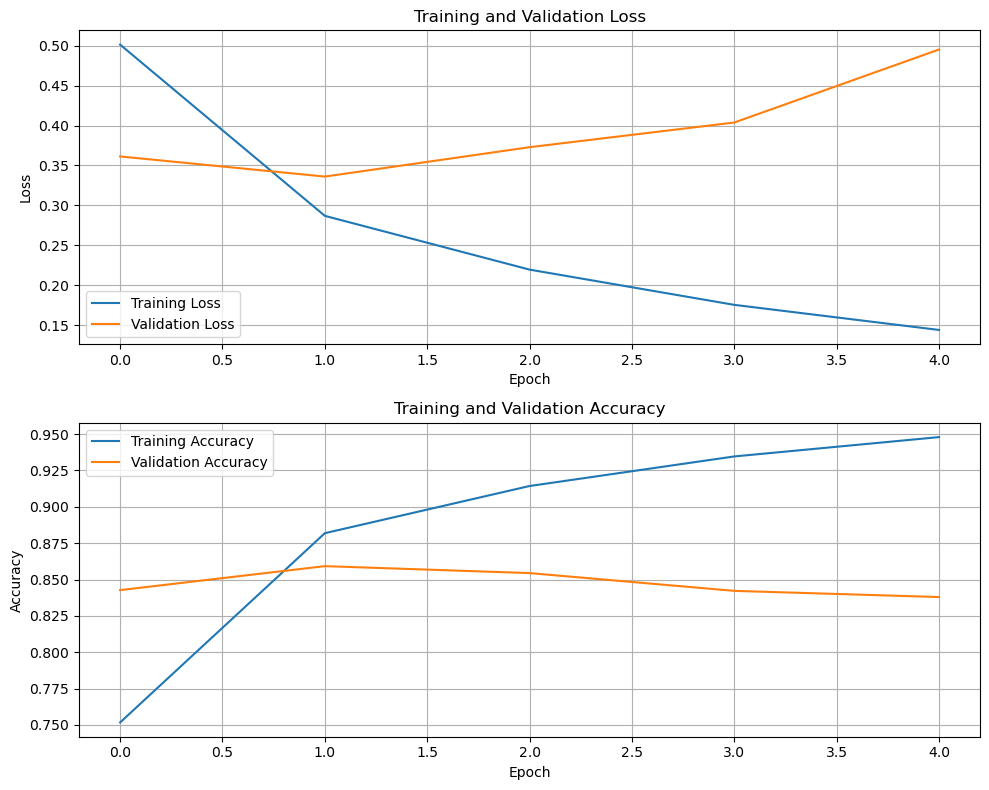

In [13]:
import matplotlib.pyplot as plt

# Plot Loss dan Accuracy
plt.figure(figsize=(10, 8))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


74/74 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1181
           1       0.00      0.00      0.00      1171

    accuracy                           0.50      2352
   macro avg       0.25      0.50      0.33      2352
weighted avg       0.25      0.50      0.34      2352



c:\Users\asus\Miniconda3\envs\python10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\Miniconda3\envs\python10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\Miniconda3\envs\python10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

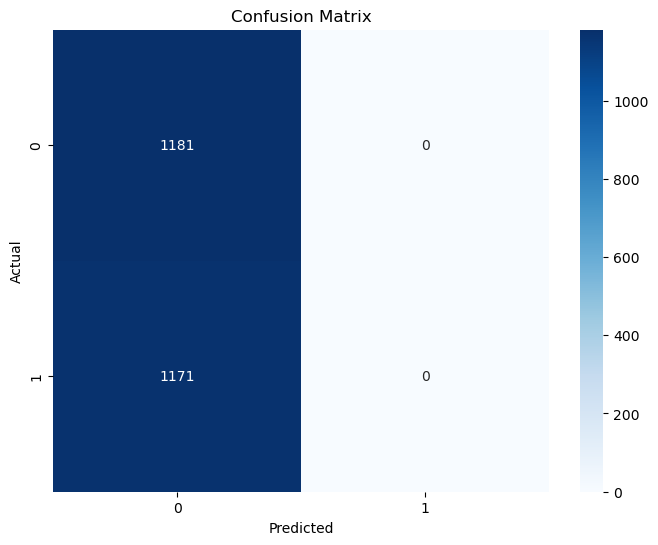

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Prediksi model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Jika y_test masih one-hot encoded, ubah ke label
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true_labels = np.argmax(y_test, axis=1)
else:
    y_true_labels = y_test

# Tampilkan classification report
print(classification_report(y_true_labels, y_pred_labels))

# Buat confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_true_labels), yticklabels=np.unique(y_true_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
model.save('../../Model/model_lstm_stress.h5')
with open('../../Model/tokenizer_stress.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [16]:
model.save('../../Model/model_lstm_stress.keras')

In [17]:
import json

with open("../../Model/tokenizer.json", "w") as f:
    json.dump(tokenizer.word_index, f)